In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from PIL import Image
import pathlib
import numpy as np
import time

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jan 13 06:38:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    48W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def get_dataloader(image_dir, batch_size):
    train_dataset = CelebAData(image_dir, transform=get_augmentation())
    dataloaders = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    return dataloaders

def get_fakelebal(image_shape):
    fake_label = torch.zeros(size=image_shape, requires_grad=False)
    return fake_label

In [5]:
class CelebAData(Dataset):

    def __init__(self, image_dir, transform=None):
        super(CelebAData, self).__init__()

        self.image_dir = image_dir
        self.transform = transform
        self.image_list = self.get_image_list()

    def get_image_list(self):
        return list(sorted(pathlib.Path(self.image_dir).glob("*.jpg")))

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_path = self.image_list[index]
        label = torch.tensor([1], dtype=torch.float)

        image = Image.open(str(image_path))

        if self.transform != None:
            image = self.transform(image)

        return image, label

def get_augmentation(image_size=128):
    train_transform = [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ]
    return transforms.Compose(train_transform)

In [6]:
class Generator(nn.Module):

    def __init__(self, channel_in, channel_out):
        super(Generator, self).__init__()

        self.channel_in = channel_in
        self.channel_out = channel_out
        net = []

        ch_in = [self.channel_in, 1024, 512, 256, 128, 64]
        ch_out = [1024, 512, 256, 128, 64, self.channel_out]
        activator = ["R", "R", "R", "R", "R", "tanh"]
        stride = [1, 2, 2, 2, 2, 2]
        padding = [0, 1, 1, 1, 1, 1]

        for i in range(len(ch_in)):
            net.append(nn.ConvTranspose2d(ch_in[i], ch_out[i], kernel_size=4
                                          , stride=stride[i], padding=padding[i]))
            if activator[i] == "R":
                net.append(nn.BatchNorm2d(ch_out[i]))
                net.append(nn.ReLU())
            elif activator[i] == "tanh":
                net.append(nn.Tanh())

        self.generator = nn.Sequential(*net)
        self.weight_init()

    def weight_init(self):
        for m in self.generator.modules():
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight.data, 0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, 0, 0.02)
                nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        out = self.generator(x)
        return out

class Disciminator(nn.Module):

    def __init__(self, channel_in):
        super(Disciminator, self).__init__()

        net = []

        ch_in = [channel_in, 64, 128, 256, 512, 1024]
        ch_out = [64, 128, 256, 512, 1024, 1]
        activator = ["LR", "LR", "LR", "LR", "LR", "sigmoid"]
        stride = 2
        padding = [1, 1, 1, 1, 1, 0]

        for i in range(len(ch_in)):
            net.append(nn.Conv2d(ch_in[i], ch_out[i], stride=stride
                                 , kernel_size=4, padding=padding[i]))

            if activator[i] == "LR":
                net.append(nn.BatchNorm2d(ch_out[i]))
                net.append(nn.LeakyReLU(negative_slope=0.2))
            elif activator[i] == "sigmoid":
                net.append(nn.Sigmoid())

        self.discriminator = nn.Sequential(*net)
        self.weight_init()

    def weight_init(self):
        for m in self.discriminator.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, 0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, 0, 0.02)
                nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        out = self.discriminator(x)
        out = out.view(x.size(0), -1)
        return out

In [7]:
import shutil
image_dir = "/content/drive/Shareddrives/MachineLearning/Colab_Notebooks/DLearning/SRGAN/Train_data"
shutil.copytree(image_dir, 'CelebA')

'CelebA'

In [7]:
"""
Model Setup
"""
batchsize = 400
epochs = 1000
ch_in = 3
ch_out = 3
image_dir = "/content/CelebA/"
model_dir = "/content/drive/Shareddrives/MachineLearning/Colab_Notebooks/DLearning/DCGAN/GAN_model/"
file_name = "_E%d_B%d_CelebA.pth"%(epochs, batchsize)
device = torch.device('cuda')

real_image = get_dataloader(image_dir, batchsize)
Gmodel = Generator(ch_in, ch_out).to(device)
Dmodel = Disciminator(ch_out).to(device)

Goptim = torch.optim.Adam(Gmodel.parameters(), lr=0.0002, betas=(0.5, 0.999))
Doptim = torch.optim.Adam(Dmodel.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()


In [8]:
# load model
# Gmodel = torch.load(model_dir+"G"+"_E500_B64.pth")
# Dmodel = torch.load(model_dir+"D"+"_E500_B64.pth")
Gmodel = torch.load(model_dir+"G"+file_name)
Dmodel = torch.load(model_dir+"D"+file_name)

----------
Epoch 1/1000
----------
Train Loss: 
G Loss : 16.6168
D Loss : 22.9823
Model saved!


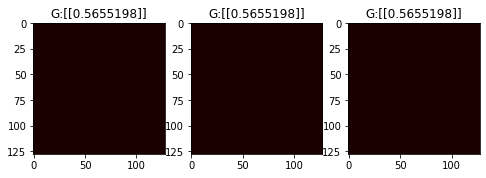

----------
Epoch 2/1000
----------
Train Loss: 
G Loss : 17.6016
D Loss : 18.3924
----------
Epoch 3/1000
----------
Train Loss: 
G Loss : 17.4466
D Loss : 18.7854
----------
Epoch 4/1000
----------
Train Loss: 
G Loss : 16.1483
D Loss : 20.2855
Model saved!
----------
Epoch 5/1000
----------
Train Loss: 
G Loss : 16.8597
D Loss : 21.0178
----------
Epoch 6/1000
----------
Train Loss: 
G Loss : 15.7802
D Loss : 21.8091
Model saved!
----------
Epoch 7/1000
----------
Train Loss: 
G Loss : 17.0317
D Loss : 18.9740
----------
Epoch 8/1000
----------
Train Loss: 
G Loss : 14.4515
D Loss : 32.2342
Model saved!
----------
Epoch 9/1000
----------
Train Loss: 
G Loss : 12.8310
D Loss : 28.4001
Model saved!
----------
Epoch 10/1000
----------
Train Loss: 
G Loss : 13.2304
D Loss : 32.0908
----------
Epoch 11/1000
----------
Train Loss: 
G Loss : 15.4299
D Loss : 22.9048


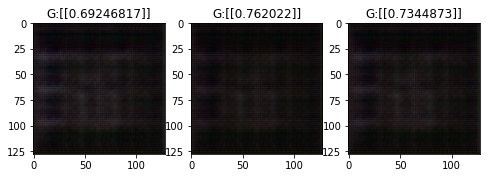

----------
Epoch 12/1000
----------
Train Loss: 
G Loss : 15.2864
D Loss : 24.3159
----------
Epoch 13/1000
----------
Train Loss: 
G Loss : 14.4539
D Loss : 26.8730
----------
Epoch 14/1000
----------
Train Loss: 
G Loss : 14.2285
D Loss : 26.2334
----------
Epoch 15/1000
----------
Train Loss: 
G Loss : 16.3172
D Loss : 24.6171
----------
Epoch 16/1000
----------
Train Loss: 
G Loss : 12.1958
D Loss : 32.1800
Model saved!
----------
Epoch 17/1000
----------
Train Loss: 
G Loss : 11.7372
D Loss : 34.2741
Model saved!
----------
Epoch 18/1000
----------
Train Loss: 
G Loss : 11.0988
D Loss : 34.1184
Model saved!
----------
Epoch 19/1000
----------
Train Loss: 
G Loss : 13.1916
D Loss : 29.3906
----------
Epoch 20/1000
----------
Train Loss: 
G Loss : 12.8250
D Loss : 32.1850
----------
Epoch 21/1000
----------
Train Loss: 
G Loss : 12.9393
D Loss : 30.3322


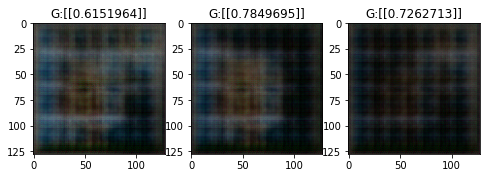

----------
Epoch 22/1000
----------
Train Loss: 
G Loss : 13.0744
D Loss : 31.9105
----------
Epoch 23/1000
----------
Train Loss: 
G Loss : 12.2535
D Loss : 31.6978
----------
Epoch 24/1000
----------
Train Loss: 
G Loss : 13.5822
D Loss : 28.7523
----------
Epoch 25/1000
----------
Train Loss: 
G Loss : 12.8607
D Loss : 31.6179
----------
Epoch 26/1000
----------
Train Loss: 
G Loss : 11.4242
D Loss : 35.7163
----------
Epoch 27/1000
----------
Train Loss: 
G Loss : 12.1120
D Loss : 32.1135
----------
Epoch 28/1000
----------
Train Loss: 
G Loss : 12.8901
D Loss : 30.1397
----------
Epoch 29/1000
----------
Train Loss: 
G Loss : 11.4157
D Loss : 33.9524
----------
Epoch 30/1000
----------
Train Loss: 
G Loss : 12.1718
D Loss : 33.2472
----------
Epoch 31/1000
----------
Train Loss: 
G Loss : 12.6648
D Loss : 31.3117


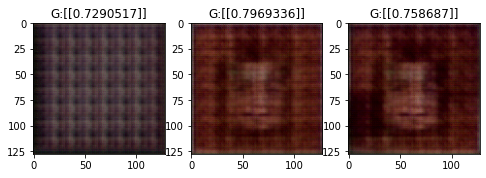

----------
Epoch 32/1000
----------
Train Loss: 
G Loss : 12.8607
D Loss : 30.5224
----------
Epoch 33/1000
----------
Train Loss: 
G Loss : 13.0165
D Loss : 32.1532
----------
Epoch 34/1000
----------
Train Loss: 
G Loss : 12.2568
D Loss : 33.3472
----------
Epoch 35/1000
----------
Train Loss: 
G Loss : 11.6648
D Loss : 32.6292
----------
Epoch 36/1000
----------
Train Loss: 
G Loss : 13.2252
D Loss : 30.6038
----------
Epoch 37/1000
----------
Train Loss: 
G Loss : 11.8783
D Loss : 31.8597
----------
Epoch 38/1000
----------
Train Loss: 
G Loss : 12.4507
D Loss : 31.4926
----------
Epoch 39/1000
----------
Train Loss: 
G Loss : 13.1607
D Loss : 31.1436
----------
Epoch 40/1000
----------
Train Loss: 
G Loss : 13.4231
D Loss : 28.5240
----------
Epoch 41/1000
----------
Train Loss: 
G Loss : 13.5317
D Loss : 29.9902


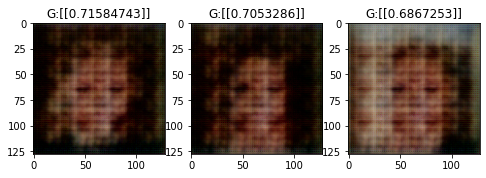

----------
Epoch 42/1000
----------
Train Loss: 
G Loss : 13.3769
D Loss : 30.6326
----------
Epoch 43/1000
----------
Train Loss: 
G Loss : 12.2623
D Loss : 32.2245
----------
Epoch 44/1000
----------
Train Loss: 
G Loss : 13.3672
D Loss : 29.6425
----------
Epoch 45/1000
----------
Train Loss: 
G Loss : 13.4070
D Loss : 32.3849
----------
Epoch 46/1000
----------
Train Loss: 
G Loss : 12.9020
D Loss : 30.0866
----------
Epoch 47/1000
----------
Train Loss: 
G Loss : 13.6969
D Loss : 28.2395
----------
Epoch 48/1000
----------
Train Loss: 
G Loss : 12.8354
D Loss : 30.6126
----------
Epoch 49/1000
----------
Train Loss: 
G Loss : 12.6501
D Loss : 31.0303
----------
Epoch 50/1000
----------
Train Loss: 
G Loss : 12.1595
D Loss : 34.1676
----------
Epoch 51/1000
----------
Train Loss: 
G Loss : 12.7173
D Loss : 29.7224


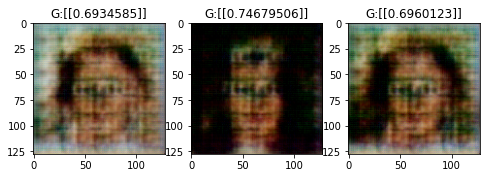

----------
Epoch 52/1000
----------
Train Loss: 
G Loss : 12.7690
D Loss : 31.8761
----------
Epoch 53/1000
----------
Train Loss: 
G Loss : 12.5051
D Loss : 32.8549
----------
Epoch 54/1000
----------
Train Loss: 
G Loss : 12.7671
D Loss : 30.2646
----------
Epoch 55/1000
----------
Train Loss: 
G Loss : 12.7395
D Loss : 31.5475
----------
Epoch 56/1000
----------
Train Loss: 
G Loss : 12.6616
D Loss : 32.1153
----------
Epoch 57/1000
----------
Train Loss: 
G Loss : 12.3963
D Loss : 31.6774
----------
Epoch 58/1000
----------
Train Loss: 
G Loss : 13.0291
D Loss : 32.7320
----------
Epoch 59/1000
----------
Train Loss: 
G Loss : 12.0353
D Loss : 32.3136
----------
Epoch 60/1000
----------
Train Loss: 
G Loss : 12.2230
D Loss : 32.3492
----------
Epoch 61/1000
----------
Train Loss: 
G Loss : 12.6462
D Loss : 31.6067


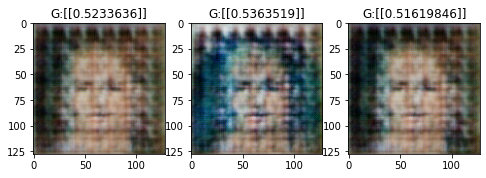

----------
Epoch 62/1000
----------
Train Loss: 
G Loss : 12.6657
D Loss : 33.1368
----------
Epoch 63/1000
----------
Train Loss: 
G Loss : 12.1279
D Loss : 31.4566
----------
Epoch 64/1000
----------
Train Loss: 
G Loss : 12.4705
D Loss : 32.4764
----------
Epoch 65/1000
----------
Train Loss: 
G Loss : 13.2237
D Loss : 30.1162
----------
Epoch 66/1000
----------
Train Loss: 
G Loss : 12.5398
D Loss : 31.7312
----------
Epoch 67/1000
----------
Train Loss: 
G Loss : 12.4131
D Loss : 32.5024
----------
Epoch 68/1000
----------
Train Loss: 
G Loss : 12.6516
D Loss : 31.4323
----------
Epoch 69/1000
----------
Train Loss: 
G Loss : 12.6685
D Loss : 31.7664
----------
Epoch 70/1000
----------
Train Loss: 
G Loss : 12.3313
D Loss : 31.7017
----------
Epoch 71/1000
----------
Train Loss: 
G Loss : 12.9911
D Loss : 31.7816


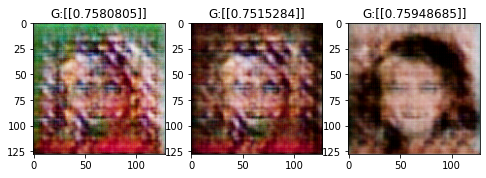

----------
Epoch 72/1000
----------
Train Loss: 
G Loss : 13.0776
D Loss : 30.5781
----------
Epoch 73/1000
----------
Train Loss: 
G Loss : 13.1017
D Loss : 29.7722
----------
Epoch 74/1000
----------
Train Loss: 
G Loss : 13.3525
D Loss : 30.9914
----------
Epoch 75/1000
----------
Train Loss: 
G Loss : 13.3423
D Loss : 31.7710
----------
Epoch 76/1000
----------
Train Loss: 
G Loss : 12.1788
D Loss : 30.5413
----------
Epoch 77/1000
----------
Train Loss: 
G Loss : 12.6433
D Loss : 32.2572
----------
Epoch 78/1000
----------
Train Loss: 
G Loss : 13.0776
D Loss : 31.4925
----------
Epoch 79/1000
----------
Train Loss: 
G Loss : 12.3972
D Loss : 31.3121
----------
Epoch 80/1000
----------
Train Loss: 
G Loss : 12.8924
D Loss : 30.3127
----------
Epoch 81/1000
----------
Train Loss: 
G Loss : 13.4446
D Loss : 31.1514


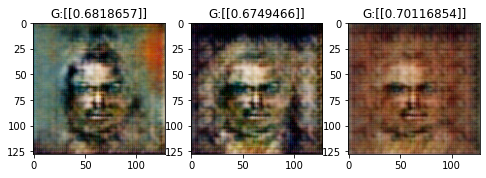

----------
Epoch 82/1000
----------
Train Loss: 
G Loss : 12.5862
D Loss : 31.3290
----------
Epoch 83/1000
----------
Train Loss: 
G Loss : 12.8306
D Loss : 31.3669
----------
Epoch 84/1000
----------
Train Loss: 
G Loss : 12.7481
D Loss : 31.6470
----------
Epoch 85/1000
----------
Train Loss: 
G Loss : 12.8848
D Loss : 31.1636
----------
Epoch 86/1000
----------
Train Loss: 
G Loss : 12.4667
D Loss : 31.5521
----------
Epoch 87/1000
----------
Train Loss: 
G Loss : 13.2841
D Loss : 31.3756
----------
Epoch 88/1000
----------
Train Loss: 
G Loss : 12.8114
D Loss : 31.1792
----------
Epoch 89/1000
----------
Train Loss: 
G Loss : 12.8346
D Loss : 30.1530
----------
Epoch 90/1000
----------
Train Loss: 
G Loss : 12.8850
D Loss : 31.3661
----------
Epoch 91/1000
----------
Train Loss: 
G Loss : 13.0128
D Loss : 31.4914


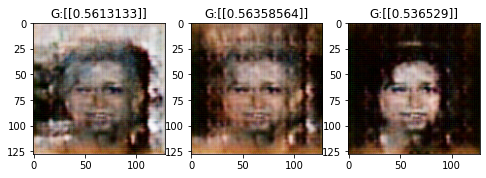

----------
Epoch 92/1000
----------
Train Loss: 
G Loss : 12.8116
D Loss : 30.9181
----------
Epoch 93/1000
----------
Train Loss: 
G Loss : 13.0523
D Loss : 30.4032
----------
Epoch 94/1000
----------
Train Loss: 
G Loss : 13.3826
D Loss : 29.7415
----------
Epoch 95/1000
----------
Train Loss: 
G Loss : 13.2471
D Loss : 30.8790
----------
Epoch 96/1000
----------
Train Loss: 
G Loss : 13.2018
D Loss : 31.0489
----------
Epoch 97/1000
----------
Train Loss: 
G Loss : 12.9066
D Loss : 30.2889
----------
Epoch 98/1000
----------
Train Loss: 
G Loss : 13.0611
D Loss : 30.6470
----------
Epoch 99/1000
----------
Train Loss: 
G Loss : 13.2286
D Loss : 29.7411
----------
Epoch 100/1000
----------
Train Loss: 
G Loss : 12.8365
D Loss : 31.2128
----------
Epoch 101/1000
----------
Train Loss: 
G Loss : 13.6123
D Loss : 29.7203


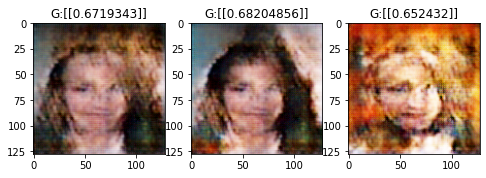

----------
Epoch 102/1000
----------
Train Loss: 
G Loss : 12.6510
D Loss : 31.3846
----------
Epoch 103/1000
----------
Train Loss: 
G Loss : 13.8842
D Loss : 30.2634
----------
Epoch 104/1000
----------
Train Loss: 
G Loss : 12.8403
D Loss : 29.8349
----------
Epoch 105/1000
----------
Train Loss: 
G Loss : 13.6145
D Loss : 30.2868
----------
Epoch 106/1000
----------
Train Loss: 
G Loss : 13.3766
D Loss : 30.5703
----------
Epoch 107/1000
----------
Train Loss: 
G Loss : 13.0124
D Loss : 29.8119
----------
Epoch 108/1000
----------
Train Loss: 
G Loss : 13.5559
D Loss : 30.0141
----------
Epoch 109/1000
----------
Train Loss: 
G Loss : 13.3563
D Loss : 30.0717
----------
Epoch 110/1000
----------
Train Loss: 
G Loss : 13.2779
D Loss : 29.4645
----------
Epoch 111/1000
----------
Train Loss: 
G Loss : 13.6729
D Loss : 30.0083


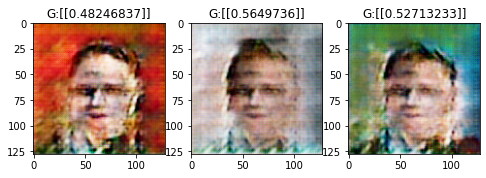

----------
Epoch 112/1000
----------
Train Loss: 
G Loss : 14.1446
D Loss : 27.4542
----------
Epoch 113/1000
----------
Train Loss: 
G Loss : 13.6617
D Loss : 30.1043
----------
Epoch 114/1000
----------
Train Loss: 
G Loss : 13.5286
D Loss : 28.9832
----------
Epoch 115/1000
----------
Train Loss: 
G Loss : 12.8367
D Loss : 30.2634
----------
Epoch 116/1000
----------
Train Loss: 
G Loss : 13.6840
D Loss : 30.1432
----------
Epoch 117/1000
----------
Train Loss: 
G Loss : 12.7645
D Loss : 30.5355
----------
Epoch 118/1000
----------
Train Loss: 
G Loss : 13.6489
D Loss : 28.8268
----------
Epoch 119/1000
----------
Train Loss: 
G Loss : 13.7802
D Loss : 29.3447
----------
Epoch 120/1000
----------
Train Loss: 
G Loss : 13.5928
D Loss : 30.7971
----------
Epoch 121/1000
----------
Train Loss: 
G Loss : 12.6596
D Loss : 30.5811


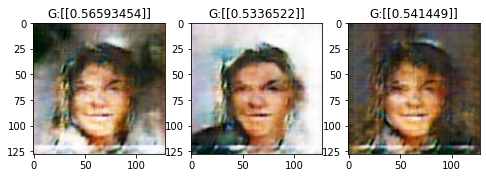

----------
Epoch 122/1000
----------
Train Loss: 
G Loss : 14.4753
D Loss : 27.6887
----------
Epoch 123/1000
----------
Train Loss: 
G Loss : 13.9453
D Loss : 29.7973
----------
Epoch 124/1000
----------
Train Loss: 
G Loss : 13.4059
D Loss : 29.2721
----------
Epoch 125/1000
----------
Train Loss: 
G Loss : 13.8102
D Loss : 29.2271
----------
Epoch 126/1000
----------
Train Loss: 
G Loss : 13.4968
D Loss : 28.3272
----------
Epoch 127/1000
----------
Train Loss: 
G Loss : 13.7849
D Loss : 28.9306
----------
Epoch 128/1000
----------
Train Loss: 
G Loss : 13.8298
D Loss : 29.0362
----------
Epoch 129/1000
----------
Train Loss: 
G Loss : 13.8417
D Loss : 28.7955
----------
Epoch 130/1000
----------
Train Loss: 
G Loss : 13.9652
D Loss : 28.7211
----------
Epoch 131/1000
----------
Train Loss: 
G Loss : 13.7038
D Loss : 29.4123


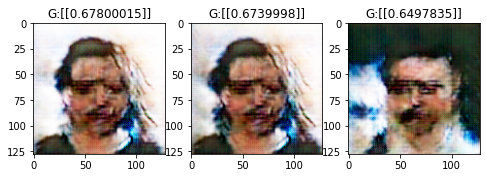

----------
Epoch 132/1000
----------
Train Loss: 
G Loss : 13.6775
D Loss : 29.3118
----------
Epoch 133/1000
----------
Train Loss: 
G Loss : 13.8850
D Loss : 30.1360
----------
Epoch 134/1000
----------
Train Loss: 
G Loss : 14.0018
D Loss : 29.3185
----------
Epoch 135/1000
----------
Train Loss: 
G Loss : 13.3434
D Loss : 28.7681
----------
Epoch 136/1000
----------
Train Loss: 
G Loss : 13.7885
D Loss : 27.8250
----------
Epoch 137/1000
----------
Train Loss: 
G Loss : 13.8779
D Loss : 29.1467
----------
Epoch 138/1000
----------
Train Loss: 
G Loss : 13.5988
D Loss : 29.7929
----------
Epoch 139/1000
----------
Train Loss: 
G Loss : 14.1210
D Loss : 30.0986
----------
Epoch 140/1000
----------
Train Loss: 
G Loss : 12.7172
D Loss : 30.0460
----------
Epoch 141/1000
----------
Train Loss: 
G Loss : 13.5189
D Loss : 29.1512


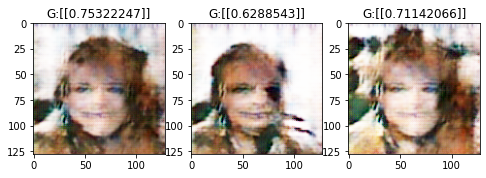

----------
Epoch 142/1000
----------
Train Loss: 
G Loss : 13.3290
D Loss : 29.6965
----------
Epoch 143/1000
----------
Train Loss: 
G Loss : 13.4824
D Loss : 28.8078
----------
Epoch 144/1000
----------
Train Loss: 
G Loss : 14.2759
D Loss : 28.7655
----------
Epoch 145/1000
----------
Train Loss: 
G Loss : 13.5375
D Loss : 29.0806
----------
Epoch 146/1000
----------
Train Loss: 
G Loss : 13.7336
D Loss : 28.1141
----------
Epoch 147/1000
----------
Train Loss: 
G Loss : 14.1977
D Loss : 30.4163
----------
Epoch 148/1000
----------
Train Loss: 
G Loss : 12.4724
D Loss : 29.8201
----------
Epoch 149/1000
----------
Train Loss: 
G Loss : 13.8078
D Loss : 30.2717
----------
Epoch 150/1000
----------
Train Loss: 
G Loss : 13.2110
D Loss : 29.4467
----------
Epoch 151/1000
----------
Train Loss: 
G Loss : 13.5457
D Loss : 28.6574


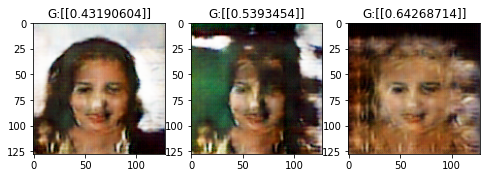

----------
Epoch 152/1000
----------
Train Loss: 
G Loss : 14.0521
D Loss : 29.0427
----------
Epoch 153/1000
----------
Train Loss: 
G Loss : 13.2802
D Loss : 30.8923
----------
Epoch 154/1000
----------
Train Loss: 
G Loss : 13.8115
D Loss : 28.6831
----------
Epoch 155/1000
----------
Train Loss: 
G Loss : 13.3728
D Loss : 28.0478
----------
Epoch 156/1000
----------
Train Loss: 
G Loss : 14.6620
D Loss : 27.2131
----------
Epoch 157/1000
----------
Train Loss: 
G Loss : 13.8949
D Loss : 28.3621
----------
Epoch 158/1000
----------
Train Loss: 
G Loss : 14.1603
D Loss : 27.5395
----------
Epoch 159/1000
----------
Train Loss: 
G Loss : 13.2788
D Loss : 29.8732
----------
Epoch 160/1000
----------
Train Loss: 
G Loss : 15.1671
D Loss : 28.9814
----------
Epoch 161/1000
----------
Train Loss: 
G Loss : 13.6530
D Loss : 29.1342


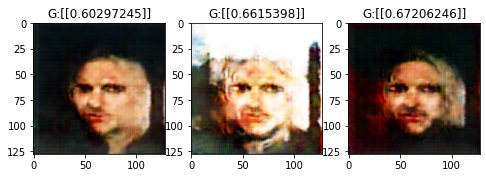

----------
Epoch 162/1000
----------
Train Loss: 
G Loss : 13.2220
D Loss : 28.5620
----------
Epoch 163/1000
----------
Train Loss: 
G Loss : 14.3248
D Loss : 28.9025
----------
Epoch 164/1000
----------
Train Loss: 
G Loss : 14.2088
D Loss : 29.1877
----------
Epoch 165/1000
----------
Train Loss: 
G Loss : 13.4865
D Loss : 27.9728
----------
Epoch 166/1000
----------
Train Loss: 
G Loss : 13.7235
D Loss : 28.1582
----------
Epoch 167/1000
----------
Train Loss: 
G Loss : 14.4395
D Loss : 28.8868
----------
Epoch 168/1000
----------
Train Loss: 
G Loss : 13.3659
D Loss : 28.4477
----------
Epoch 169/1000
----------
Train Loss: 
G Loss : 14.4425
D Loss : 27.2945
----------
Epoch 170/1000
----------
Train Loss: 
G Loss : 14.8378
D Loss : 27.8615
----------
Epoch 171/1000
----------
Train Loss: 
G Loss : 13.5161
D Loss : 27.8261


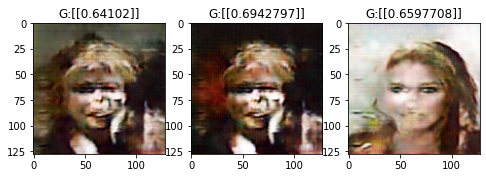

----------
Epoch 172/1000
----------
Train Loss: 
G Loss : 14.3816
D Loss : 27.7796
----------
Epoch 173/1000
----------
Train Loss: 
G Loss : 14.5523
D Loss : 27.0911
----------
Epoch 174/1000
----------
Train Loss: 
G Loss : 14.5020
D Loss : 26.6444
----------
Epoch 175/1000
----------
Train Loss: 
G Loss : 14.6133
D Loss : 27.0141
----------
Epoch 176/1000
----------
Train Loss: 
G Loss : 14.0234
D Loss : 27.2723
----------
Epoch 177/1000
----------
Train Loss: 
G Loss : 14.2299
D Loss : 29.0453
----------
Epoch 178/1000
----------
Train Loss: 
G Loss : 14.1291
D Loss : 28.3243
----------
Epoch 179/1000
----------
Train Loss: 
G Loss : 14.5824
D Loss : 28.5458
----------
Epoch 180/1000
----------
Train Loss: 
G Loss : 13.5838
D Loss : 29.0128
----------
Epoch 181/1000
----------
Train Loss: 
G Loss : 14.1554
D Loss : 26.7328


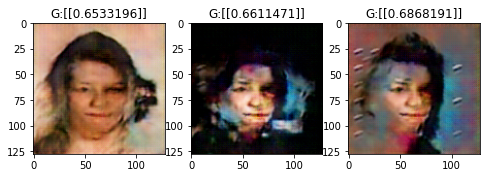

----------
Epoch 182/1000
----------
Train Loss: 
G Loss : 14.2931
D Loss : 27.5880
----------
Epoch 183/1000
----------
Train Loss: 
G Loss : 14.4735
D Loss : 27.0075
----------
Epoch 184/1000
----------
Train Loss: 
G Loss : 14.3802
D Loss : 27.6804
----------
Epoch 185/1000
----------
Train Loss: 
G Loss : 13.5533
D Loss : 27.5976
----------
Epoch 186/1000
----------
Train Loss: 
G Loss : 14.3100
D Loss : 28.6726
----------
Epoch 187/1000
----------
Train Loss: 
G Loss : 13.9517
D Loss : 28.4259
----------
Epoch 188/1000
----------
Train Loss: 
G Loss : 14.3912
D Loss : 28.0530
----------
Epoch 189/1000
----------
Train Loss: 
G Loss : 13.8786
D Loss : 27.7002
----------
Epoch 190/1000
----------
Train Loss: 
G Loss : 14.1055
D Loss : 27.2796
----------
Epoch 191/1000
----------
Train Loss: 
G Loss : 14.7345
D Loss : 28.0812


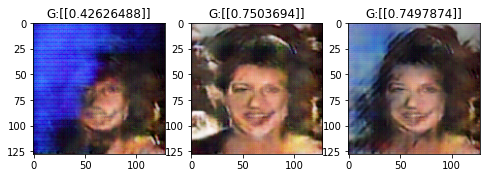

----------
Epoch 192/1000
----------
Train Loss: 
G Loss : 14.2186
D Loss : 26.8532
----------
Epoch 193/1000
----------
Train Loss: 
G Loss : 13.9998
D Loss : 28.3923
----------
Epoch 194/1000
----------
Train Loss: 
G Loss : 14.3834
D Loss : 29.0863
----------
Epoch 195/1000
----------
Train Loss: 
G Loss : 13.6923
D Loss : 27.3282
----------
Epoch 196/1000
----------
Train Loss: 
G Loss : 14.9578
D Loss : 27.4750
----------
Epoch 197/1000
----------
Train Loss: 
G Loss : 14.0988
D Loss : 26.7156
----------
Epoch 198/1000
----------
Train Loss: 
G Loss : 14.3989
D Loss : 27.4178
----------
Epoch 199/1000
----------
Train Loss: 
G Loss : 14.3108
D Loss : 28.0063
----------
Epoch 200/1000
----------
Train Loss: 
G Loss : 14.3559
D Loss : 28.0030
----------
Epoch 201/1000
----------
Train Loss: 
G Loss : 14.2803
D Loss : 28.6116


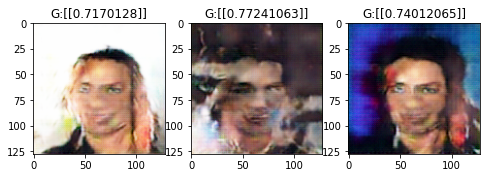

----------
Epoch 202/1000
----------
Train Loss: 
G Loss : 14.2735
D Loss : 27.1789
----------
Epoch 203/1000
----------
Train Loss: 
G Loss : 13.8705
D Loss : 28.2086
----------
Epoch 204/1000
----------
Train Loss: 
G Loss : 14.5891
D Loss : 26.0799
----------
Epoch 205/1000
----------
Train Loss: 
G Loss : 14.7549
D Loss : 27.2917
----------
Epoch 206/1000
----------
Train Loss: 
G Loss : 13.6997
D Loss : 28.3853
----------
Epoch 207/1000
----------
Train Loss: 
G Loss : 14.3200
D Loss : 27.8391
----------
Epoch 208/1000
----------
Train Loss: 
G Loss : 14.0344
D Loss : 28.4963
----------
Epoch 209/1000
----------
Train Loss: 
G Loss : 14.1268
D Loss : 27.2862
----------
Epoch 210/1000
----------
Train Loss: 
G Loss : 14.6097
D Loss : 28.2279
----------
Epoch 211/1000
----------
Train Loss: 
G Loss : 13.8711
D Loss : 28.5935


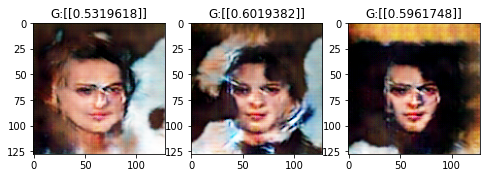

----------
Epoch 212/1000
----------
Train Loss: 
G Loss : 14.1765
D Loss : 26.0428
----------
Epoch 213/1000
----------
Train Loss: 
G Loss : 15.6780
D Loss : 29.0437
----------
Epoch 214/1000
----------
Train Loss: 
G Loss : 14.1121
D Loss : 27.3173
----------
Epoch 215/1000
----------
Train Loss: 
G Loss : 14.1864
D Loss : 27.3398
----------
Epoch 216/1000
----------
Train Loss: 
G Loss : 14.0401
D Loss : 26.5501
----------
Epoch 217/1000
----------
Train Loss: 
G Loss : 14.0019
D Loss : 29.2068
----------
Epoch 218/1000
----------
Train Loss: 
G Loss : 15.0456
D Loss : 26.3893
----------
Epoch 219/1000
----------
Train Loss: 
G Loss : 14.8935
D Loss : 28.1879
----------
Epoch 220/1000
----------
Train Loss: 
G Loss : 13.5138
D Loss : 27.7328
----------
Epoch 221/1000
----------
Train Loss: 
G Loss : 14.5528
D Loss : 26.8326


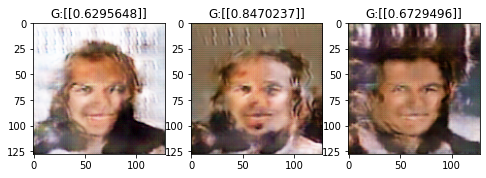

----------
Epoch 222/1000
----------
Train Loss: 
G Loss : 14.8861
D Loss : 28.1513
----------
Epoch 223/1000
----------
Train Loss: 
G Loss : 13.6163
D Loss : 27.7486
----------
Epoch 224/1000
----------
Train Loss: 
G Loss : 13.5608
D Loss : 28.7081
----------
Epoch 225/1000
----------
Train Loss: 
G Loss : 14.4385
D Loss : 27.3748
----------
Epoch 226/1000
----------
Train Loss: 
G Loss : 15.0166
D Loss : 27.7478
----------
Epoch 227/1000
----------
Train Loss: 
G Loss : 13.4464
D Loss : 28.4860
----------
Epoch 228/1000
----------
Train Loss: 
G Loss : 14.6889
D Loss : 28.2351
----------
Epoch 229/1000
----------
Train Loss: 
G Loss : 14.1199
D Loss : 26.1985
----------
Epoch 230/1000
----------
Train Loss: 
G Loss : 14.2802
D Loss : 28.9944
----------
Epoch 231/1000
----------
Train Loss: 
G Loss : 13.9247
D Loss : 27.3221


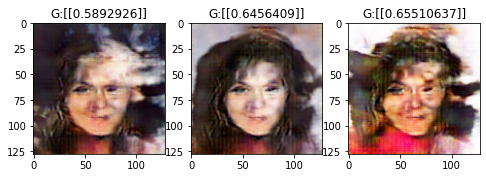

----------
Epoch 232/1000
----------
Train Loss: 
G Loss : 14.1082
D Loss : 27.5061
----------
Epoch 233/1000
----------
Train Loss: 
G Loss : 14.2458
D Loss : 27.7921
----------
Epoch 234/1000
----------
Train Loss: 
G Loss : 14.1464
D Loss : 28.3784
----------
Epoch 235/1000
----------
Train Loss: 
G Loss : 14.8255
D Loss : 26.7662
----------
Epoch 236/1000
----------
Train Loss: 
G Loss : 14.5661
D Loss : 27.2536
----------
Epoch 237/1000
----------
Train Loss: 
G Loss : 15.6824
D Loss : 28.2638
----------
Epoch 238/1000
----------
Train Loss: 
G Loss : 14.1159
D Loss : 25.5258
----------
Epoch 239/1000
----------
Train Loss: 
G Loss : 15.1142
D Loss : 27.0132
----------
Epoch 240/1000
----------
Train Loss: 
G Loss : 13.9383
D Loss : 26.8916
----------
Epoch 241/1000
----------
Train Loss: 
G Loss : 14.6114
D Loss : 27.6204


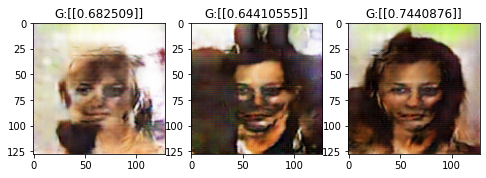

----------
Epoch 242/1000
----------
Train Loss: 
G Loss : 14.0107
D Loss : 27.3666
----------
Epoch 243/1000
----------
Train Loss: 
G Loss : 14.4961
D Loss : 25.8751
----------
Epoch 244/1000
----------
Train Loss: 
G Loss : 15.1281
D Loss : 26.3509
----------
Epoch 245/1000
----------
Train Loss: 
G Loss : 14.4114
D Loss : 28.0971
----------
Epoch 246/1000
----------
Train Loss: 
G Loss : 14.2770
D Loss : 26.5425
----------
Epoch 247/1000
----------
Train Loss: 
G Loss : 13.9511
D Loss : 28.5705
----------
Epoch 248/1000
----------
Train Loss: 
G Loss : 14.0840
D Loss : 29.1704
----------
Epoch 249/1000
----------
Train Loss: 
G Loss : 14.1066
D Loss : 27.9640
----------
Epoch 250/1000
----------
Train Loss: 
G Loss : 14.2372
D Loss : 26.2484
----------
Epoch 251/1000
----------
Train Loss: 
G Loss : 14.5789
D Loss : 27.6446


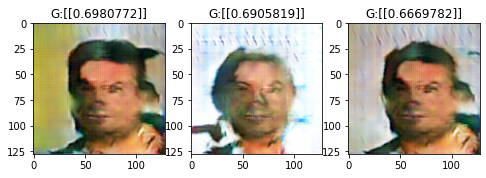

----------
Epoch 252/1000
----------
Train Loss: 
G Loss : 14.6433
D Loss : 27.4834
----------
Epoch 253/1000
----------
Train Loss: 
G Loss : 14.3871
D Loss : 27.1960
----------
Epoch 254/1000
----------
Train Loss: 
G Loss : 14.0496
D Loss : 26.1609
----------
Epoch 255/1000
----------
Train Loss: 
G Loss : 14.5020
D Loss : 27.6634
----------
Epoch 256/1000
----------
Train Loss: 
G Loss : 15.1686
D Loss : 27.7178
----------
Epoch 257/1000
----------
Train Loss: 
G Loss : 14.0813
D Loss : 27.1606
----------
Epoch 258/1000
----------
Train Loss: 
G Loss : 14.1058
D Loss : 27.1997
----------
Epoch 259/1000
----------
Train Loss: 
G Loss : 14.1536
D Loss : 27.4754
----------
Epoch 260/1000
----------
Train Loss: 
G Loss : 14.4529
D Loss : 26.9749
----------
Epoch 261/1000
----------
Train Loss: 
G Loss : 14.3572
D Loss : 27.7023


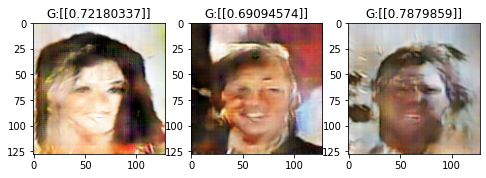

----------
Epoch 262/1000
----------
Train Loss: 
G Loss : 14.9185
D Loss : 26.5374
----------
Epoch 263/1000
----------
Train Loss: 
G Loss : 14.2283
D Loss : 27.7975
----------
Epoch 264/1000
----------
Train Loss: 
G Loss : 14.2213
D Loss : 27.2589
----------
Epoch 265/1000
----------
Train Loss: 
G Loss : 14.2387
D Loss : 28.0676
----------
Epoch 266/1000
----------
Train Loss: 
G Loss : 14.0495
D Loss : 27.6654
----------
Epoch 267/1000
----------
Train Loss: 
G Loss : 14.2912
D Loss : 26.8947
----------
Epoch 268/1000
----------
Train Loss: 
G Loss : 14.3814
D Loss : 27.8632
----------
Epoch 269/1000
----------
Train Loss: 
G Loss : 14.1789
D Loss : 27.9775
----------
Epoch 270/1000
----------
Train Loss: 
G Loss : 13.9956
D Loss : 27.8640
----------
Epoch 271/1000
----------
Train Loss: 
G Loss : 14.8767
D Loss : 27.0648


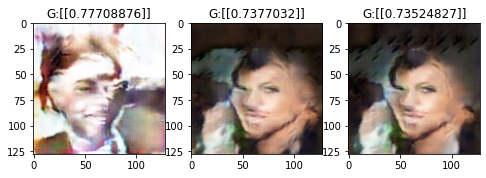

----------
Epoch 272/1000
----------
Train Loss: 
G Loss : 14.4915
D Loss : 27.9514
----------
Epoch 273/1000
----------
Train Loss: 
G Loss : 13.7861
D Loss : 27.3512
----------
Epoch 274/1000
----------
Train Loss: 
G Loss : 14.4704
D Loss : 25.9681
----------
Epoch 275/1000
----------
Train Loss: 
G Loss : 14.8747
D Loss : 27.1347
----------
Epoch 276/1000
----------
Train Loss: 
G Loss : 14.8124
D Loss : 27.7309
----------
Epoch 277/1000
----------
Train Loss: 
G Loss : 14.7659
D Loss : 26.1994
----------
Epoch 278/1000
----------
Train Loss: 
G Loss : 14.7108
D Loss : 27.4460
----------
Epoch 279/1000
----------
Train Loss: 
G Loss : 13.8175
D Loss : 27.0022
----------
Epoch 280/1000
----------
Train Loss: 
G Loss : 14.2697
D Loss : 27.0288
----------
Epoch 281/1000
----------
Train Loss: 
G Loss : 14.3426
D Loss : 26.4721


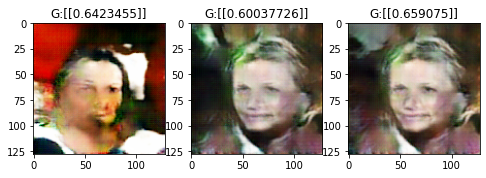

----------
Epoch 282/1000
----------
Train Loss: 
G Loss : 14.8038
D Loss : 27.5784
----------
Epoch 283/1000
----------
Train Loss: 
G Loss : 14.1537
D Loss : 28.1692
----------
Epoch 284/1000
----------
Train Loss: 
G Loss : 14.7468
D Loss : 26.7904
----------
Epoch 285/1000
----------
Train Loss: 
G Loss : 14.4431
D Loss : 27.4426
----------
Epoch 286/1000
----------
Train Loss: 
G Loss : 14.4554
D Loss : 27.4993
----------
Epoch 287/1000
----------
Train Loss: 
G Loss : 14.8894
D Loss : 27.0721
----------
Epoch 288/1000
----------
Train Loss: 
G Loss : 14.1141
D Loss : 27.5285
----------
Epoch 289/1000
----------
Train Loss: 
G Loss : 14.6902
D Loss : 27.5727
----------
Epoch 290/1000
----------
Train Loss: 
G Loss : 13.9628
D Loss : 27.3134
----------
Epoch 291/1000
----------
Train Loss: 
G Loss : 14.4825
D Loss : 27.5025


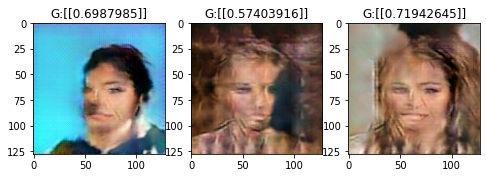

----------
Epoch 292/1000
----------
Train Loss: 
G Loss : 14.2624
D Loss : 28.1812
----------
Epoch 293/1000
----------
Train Loss: 
G Loss : 14.2488
D Loss : 27.7411
----------
Epoch 294/1000
----------
Train Loss: 
G Loss : 14.4152
D Loss : 27.4756
----------
Epoch 295/1000
----------
Train Loss: 
G Loss : 15.0059
D Loss : 26.8452
----------
Epoch 296/1000
----------
Train Loss: 
G Loss : 14.7238
D Loss : 26.9293
----------
Epoch 297/1000
----------
Train Loss: 
G Loss : 14.9832
D Loss : 26.2328
----------
Epoch 298/1000
----------
Train Loss: 
G Loss : 13.7128
D Loss : 28.4874
----------
Epoch 299/1000
----------
Train Loss: 
G Loss : 14.7471
D Loss : 26.9748
----------
Epoch 300/1000
----------
Train Loss: 
G Loss : 14.2759
D Loss : 26.8487
----------
Epoch 301/1000
----------
Train Loss: 
G Loss : 14.9189
D Loss : 27.7869


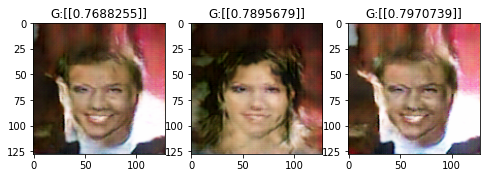

----------
Epoch 302/1000
----------
Train Loss: 
G Loss : 13.7008
D Loss : 27.9379
----------
Epoch 303/1000
----------
Train Loss: 
G Loss : 14.6514
D Loss : 26.2610
----------
Epoch 304/1000
----------
Train Loss: 
G Loss : 14.6802
D Loss : 26.2290
----------
Epoch 305/1000
----------
Train Loss: 
G Loss : 14.6240
D Loss : 27.3279
----------
Epoch 306/1000
----------
Train Loss: 
G Loss : 14.5224
D Loss : 27.7639
----------
Epoch 307/1000
----------
Train Loss: 
G Loss : 14.2818
D Loss : 25.9371
----------
Epoch 308/1000
----------
Train Loss: 
G Loss : 14.8980
D Loss : 26.1763
----------
Epoch 309/1000
----------
Train Loss: 
G Loss : 14.8630
D Loss : 26.6230
----------
Epoch 310/1000
----------
Train Loss: 
G Loss : 14.8202
D Loss : 27.1453
----------
Epoch 311/1000
----------
Train Loss: 
G Loss : 14.5624
D Loss : 26.1717


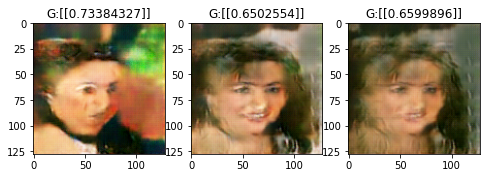

----------
Epoch 312/1000
----------
Train Loss: 
G Loss : 14.8731
D Loss : 27.6918
----------
Epoch 313/1000
----------
Train Loss: 
G Loss : 15.0632
D Loss : 26.2935
----------
Epoch 314/1000
----------
Train Loss: 
G Loss : 14.6109
D Loss : 26.2831
----------
Epoch 315/1000
----------
Train Loss: 
G Loss : 14.3771
D Loss : 26.5607
----------
Epoch 316/1000
----------
Train Loss: 
G Loss : 13.6142
D Loss : 27.4571
----------
Epoch 317/1000
----------
Train Loss: 
G Loss : 15.0432
D Loss : 28.1763
----------
Epoch 318/1000
----------
Train Loss: 
G Loss : 14.0716
D Loss : 26.3797
----------
Epoch 319/1000
----------
Train Loss: 
G Loss : 15.2750
D Loss : 26.9667
----------
Epoch 320/1000
----------
Train Loss: 
G Loss : 14.3814
D Loss : 27.1077
----------
Epoch 321/1000
----------
Train Loss: 
G Loss : 14.8350
D Loss : 25.1336


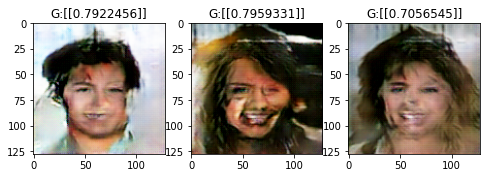

----------
Epoch 322/1000
----------
Train Loss: 
G Loss : 15.6038
D Loss : 26.0361
----------
Epoch 323/1000
----------
Train Loss: 
G Loss : 13.9850
D Loss : 26.7406
----------
Epoch 324/1000
----------
Train Loss: 
G Loss : 15.0823
D Loss : 26.2530
----------
Epoch 325/1000
----------
Train Loss: 
G Loss : 14.5676
D Loss : 27.3819
----------
Epoch 326/1000
----------
Train Loss: 
G Loss : 15.0196
D Loss : 27.2240
----------
Epoch 327/1000
----------
Train Loss: 
G Loss : 13.5637
D Loss : 27.5928
----------
Epoch 328/1000
----------
Train Loss: 
G Loss : 15.2482
D Loss : 25.5043
----------
Epoch 329/1000
----------
Train Loss: 
G Loss : 15.5236
D Loss : 25.2720
----------
Epoch 330/1000
----------
Train Loss: 
G Loss : 15.4500
D Loss : 26.7027
----------
Epoch 331/1000
----------
Train Loss: 
G Loss : 14.0888
D Loss : 26.9099


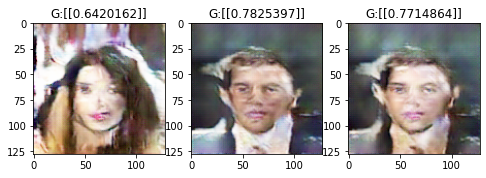

----------
Epoch 332/1000
----------
Train Loss: 
G Loss : 13.9666
D Loss : 26.7992
----------
Epoch 333/1000
----------
Train Loss: 
G Loss : 14.5944
D Loss : 26.8335
----------
Epoch 334/1000
----------
Train Loss: 
G Loss : 14.6981
D Loss : 26.9991
----------
Epoch 335/1000
----------
Train Loss: 
G Loss : 14.5227
D Loss : 26.6241
----------
Epoch 336/1000
----------
Train Loss: 
G Loss : 14.6816
D Loss : 26.7488
----------
Epoch 337/1000
----------
Train Loss: 
G Loss : 14.1680
D Loss : 26.4678
----------
Epoch 338/1000
----------
Train Loss: 
G Loss : 15.3434
D Loss : 27.1539
----------
Epoch 339/1000
----------
Train Loss: 
G Loss : 14.3196
D Loss : 27.1104
----------
Epoch 340/1000
----------
Train Loss: 
G Loss : 15.0262
D Loss : 25.9648
----------
Epoch 341/1000
----------
Train Loss: 
G Loss : 14.3265
D Loss : 26.3346


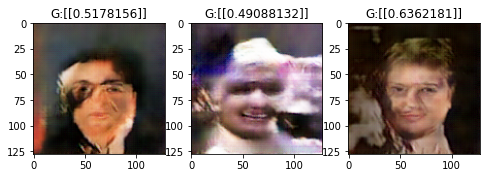

----------
Epoch 342/1000
----------
Train Loss: 
G Loss : 14.7924
D Loss : 27.4722
----------
Epoch 343/1000
----------
Train Loss: 
G Loss : 14.6163
D Loss : 27.0518
----------
Epoch 344/1000
----------
Train Loss: 
G Loss : 14.4232
D Loss : 26.7240
----------
Epoch 345/1000
----------
Train Loss: 
G Loss : 14.8872
D Loss : 25.9290
----------
Epoch 346/1000
----------
Train Loss: 
G Loss : 14.7274
D Loss : 25.9672
----------
Epoch 347/1000
----------
Train Loss: 
G Loss : 15.2691
D Loss : 26.5564
----------
Epoch 348/1000
----------
Train Loss: 
G Loss : 14.3335
D Loss : 26.4305
----------
Epoch 349/1000
----------
Train Loss: 
G Loss : 15.7081
D Loss : 25.4129
----------
Epoch 350/1000
----------
Train Loss: 
G Loss : 14.1656
D Loss : 28.4313
----------
Epoch 351/1000
----------
Train Loss: 
G Loss : 14.6790
D Loss : 27.3182


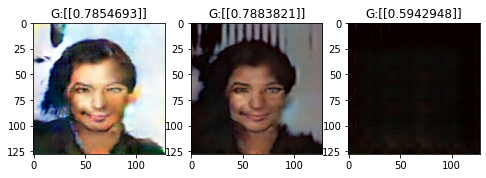

----------
Epoch 352/1000
----------
Train Loss: 
G Loss : 14.6641
D Loss : 26.5484
----------
Epoch 353/1000
----------
Train Loss: 
G Loss : 14.1450
D Loss : 27.1596
----------
Epoch 354/1000
----------
Train Loss: 
G Loss : 15.0072
D Loss : 28.4226
----------
Epoch 355/1000
----------
Train Loss: 
G Loss : 14.6330
D Loss : 27.1606
----------
Epoch 356/1000
----------
Train Loss: 
G Loss : 14.2422
D Loss : 26.8358
----------
Epoch 357/1000
----------
Train Loss: 
G Loss : 14.7754
D Loss : 27.4914
----------
Epoch 358/1000
----------
Train Loss: 
G Loss : 14.1694
D Loss : 25.8942
----------
Epoch 359/1000
----------
Train Loss: 
G Loss : 14.8652
D Loss : 28.1750
----------
Epoch 360/1000
----------
Train Loss: 
G Loss : 14.5612
D Loss : 27.3505
----------
Epoch 361/1000
----------
Train Loss: 
G Loss : 14.1040
D Loss : 26.4976


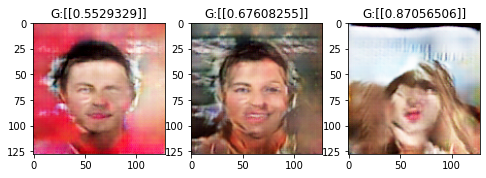

----------
Epoch 362/1000
----------
Train Loss: 
G Loss : 14.8417
D Loss : 26.1943
----------
Epoch 363/1000
----------
Train Loss: 
G Loss : 14.4561
D Loss : 26.6884
----------
Epoch 364/1000
----------
Train Loss: 
G Loss : 15.0340
D Loss : 28.5136
----------
Epoch 365/1000
----------
Train Loss: 
G Loss : 14.5471
D Loss : 26.3896
----------
Epoch 366/1000
----------
Train Loss: 
G Loss : 15.1112
D Loss : 26.2423
----------
Epoch 367/1000
----------
Train Loss: 
G Loss : 15.1739
D Loss : 25.7123
----------
Epoch 368/1000
----------
Train Loss: 
G Loss : 15.0974
D Loss : 25.6422
----------
Epoch 369/1000
----------
Train Loss: 
G Loss : 14.7043
D Loss : 25.2788
----------
Epoch 370/1000
----------
Train Loss: 
G Loss : 14.9622
D Loss : 26.2547
----------
Epoch 371/1000
----------
Train Loss: 
G Loss : 15.0509
D Loss : 27.1119


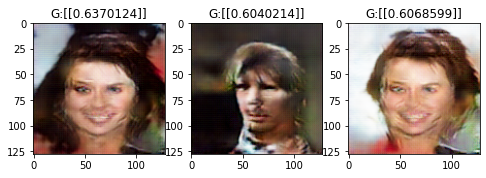

----------
Epoch 372/1000
----------
Train Loss: 
G Loss : 14.5672
D Loss : 25.2487
----------
Epoch 373/1000
----------
Train Loss: 
G Loss : 15.1679
D Loss : 27.2857
----------
Epoch 374/1000
----------
Train Loss: 
G Loss : 15.1529
D Loss : 25.7908
----------
Epoch 375/1000
----------
Train Loss: 
G Loss : 14.7580
D Loss : 25.4273
----------
Epoch 376/1000
----------
Train Loss: 
G Loss : 14.6842
D Loss : 25.7591
----------
Epoch 377/1000
----------
Train Loss: 
G Loss : 15.2341
D Loss : 27.3369
----------
Epoch 378/1000
----------
Train Loss: 
G Loss : 14.5889
D Loss : 25.8170
----------
Epoch 379/1000
----------
Train Loss: 
G Loss : 14.9532
D Loss : 26.7104
----------
Epoch 380/1000
----------
Train Loss: 
G Loss : 14.8797
D Loss : 25.8505
----------
Epoch 381/1000
----------
Train Loss: 
G Loss : 15.4514
D Loss : 25.5803


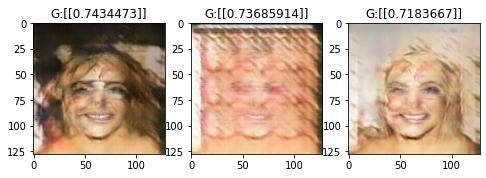

----------
Epoch 382/1000
----------
Train Loss: 
G Loss : 15.0367
D Loss : 26.4169
----------
Epoch 383/1000
----------
Train Loss: 
G Loss : 14.4253
D Loss : 26.0819
----------
Epoch 384/1000
----------
Train Loss: 
G Loss : 15.3989
D Loss : 25.3948
----------
Epoch 385/1000
----------
Train Loss: 
G Loss : 14.5649
D Loss : 26.2858
----------
Epoch 386/1000
----------
Train Loss: 
G Loss : 15.3119
D Loss : 25.6164
----------
Epoch 387/1000
----------
Train Loss: 
G Loss : 14.5481
D Loss : 26.0544
----------
Epoch 388/1000
----------
Train Loss: 
G Loss : 14.8311
D Loss : 26.5941
----------
Epoch 389/1000
----------
Train Loss: 
G Loss : 14.8448
D Loss : 25.4058
----------
Epoch 390/1000
----------
Train Loss: 
G Loss : 15.7556
D Loss : 26.7267
----------
Epoch 391/1000
----------
Train Loss: 
G Loss : 14.6537
D Loss : 25.9709


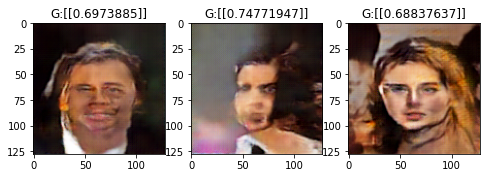

----------
Epoch 392/1000
----------
Train Loss: 
G Loss : 15.3627
D Loss : 24.4071
----------
Epoch 393/1000
----------
Train Loss: 
G Loss : 15.0327
D Loss : 26.7476
----------
Epoch 394/1000
----------
Train Loss: 
G Loss : 14.8482
D Loss : 25.8426
----------
Epoch 395/1000
----------
Train Loss: 
G Loss : 15.2988
D Loss : 25.1515
----------
Epoch 396/1000
----------
Train Loss: 
G Loss : 15.4203
D Loss : 25.7665
----------
Epoch 397/1000
----------
Train Loss: 
G Loss : 14.5702
D Loss : 26.9520
----------
Epoch 398/1000
----------
Train Loss: 
G Loss : 15.3188
D Loss : 24.9741
----------
Epoch 399/1000
----------
Train Loss: 
G Loss : 14.6290
D Loss : 26.2344
----------
Epoch 400/1000
----------
Train Loss: 
G Loss : 15.1885
D Loss : 26.0086
----------
Epoch 401/1000
----------
Train Loss: 
G Loss : 14.3955
D Loss : 26.4713


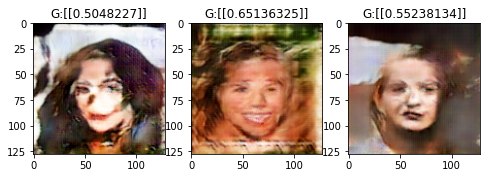

----------
Epoch 402/1000
----------
Train Loss: 
G Loss : 14.9486
D Loss : 26.3287
----------
Epoch 403/1000
----------
Train Loss: 
G Loss : 14.4125
D Loss : 26.5926
----------
Epoch 404/1000
----------
Train Loss: 
G Loss : 14.7104
D Loss : 26.3419
----------
Epoch 405/1000
----------
Train Loss: 
G Loss : 14.8588
D Loss : 25.2684
----------
Epoch 406/1000
----------
Train Loss: 
G Loss : 14.8733
D Loss : 27.9572
----------
Epoch 407/1000
----------
Train Loss: 
G Loss : 14.6273
D Loss : 26.0593
----------
Epoch 408/1000
----------
Train Loss: 
G Loss : 14.9628
D Loss : 27.0044
----------
Epoch 409/1000
----------
Train Loss: 
G Loss : 14.8893
D Loss : 26.1534
----------
Epoch 410/1000
----------
Train Loss: 
G Loss : 14.9549
D Loss : 25.7675
----------
Epoch 411/1000
----------
Train Loss: 
G Loss : 14.7995
D Loss : 26.8842


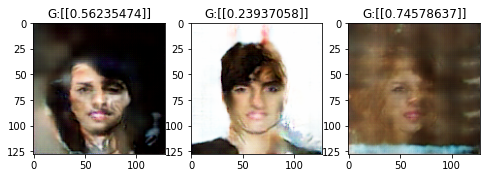

----------
Epoch 412/1000
----------
Train Loss: 
G Loss : 15.6607
D Loss : 25.1550
----------
Epoch 413/1000
----------
Train Loss: 
G Loss : 15.1371
D Loss : 25.8736
----------
Epoch 414/1000
----------
Train Loss: 
G Loss : 14.8745
D Loss : 26.2882
----------
Epoch 415/1000
----------
Train Loss: 
G Loss : 14.2575
D Loss : 26.4661
----------
Epoch 416/1000
----------
Train Loss: 
G Loss : 14.9150
D Loss : 25.8613
----------
Epoch 417/1000
----------
Train Loss: 
G Loss : 14.7523
D Loss : 26.6193
----------
Epoch 418/1000
----------
Train Loss: 
G Loss : 14.7128
D Loss : 26.1923
----------
Epoch 419/1000
----------
Train Loss: 
G Loss : 15.3433
D Loss : 26.9836
----------
Epoch 420/1000
----------
Train Loss: 
G Loss : 14.6021
D Loss : 26.0895
----------
Epoch 421/1000
----------
Train Loss: 
G Loss : 14.8956
D Loss : 25.1984


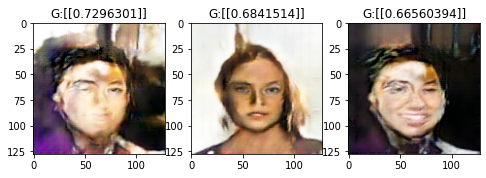

----------
Epoch 422/1000
----------
Train Loss: 
G Loss : 14.8537
D Loss : 26.4849
----------
Epoch 423/1000
----------
Train Loss: 
G Loss : 14.9104
D Loss : 25.7034
----------
Epoch 424/1000
----------
Train Loss: 
G Loss : 14.9475
D Loss : 26.8837
----------
Epoch 425/1000
----------
Train Loss: 
G Loss : 14.6421
D Loss : 24.9037
----------
Epoch 426/1000
----------
Train Loss: 
G Loss : 15.2392
D Loss : 24.7671
----------
Epoch 427/1000
----------
Train Loss: 
G Loss : 15.1765
D Loss : 26.5280
----------
Epoch 428/1000
----------
Train Loss: 
G Loss : 14.6567
D Loss : 25.3211
----------
Epoch 429/1000
----------
Train Loss: 
G Loss : 15.0016
D Loss : 26.7555
----------
Epoch 430/1000
----------
Train Loss: 
G Loss : 14.6652
D Loss : 26.2141
----------
Epoch 431/1000
----------
Train Loss: 
G Loss : 15.1697
D Loss : 27.7295


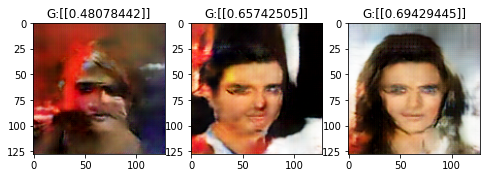

----------
Epoch 432/1000
----------
Train Loss: 
G Loss : 14.6830
D Loss : 25.9592
----------
Epoch 433/1000
----------
Train Loss: 
G Loss : 15.3642
D Loss : 26.9995
----------
Epoch 434/1000
----------
Train Loss: 
G Loss : 14.2137
D Loss : 27.4929
----------
Epoch 435/1000
----------
Train Loss: 
G Loss : 14.6117
D Loss : 26.3787
----------
Epoch 436/1000
----------
Train Loss: 
G Loss : 14.6698
D Loss : 26.0910
----------
Epoch 437/1000
----------
Train Loss: 
G Loss : 15.4442
D Loss : 25.9862
----------
Epoch 438/1000
----------
Train Loss: 
G Loss : 14.6291
D Loss : 26.2916
----------
Epoch 439/1000
----------


In [ ]:
g_loss_recorder = []
d_loss_recorder = []

since = time.time()

Gmodel.weight_init()
Dmodel.weight_init()

for i in range(epochs):
    Gmodel.train()
    Dmodel.train()

    print('-' * 10)
    print('Epoch {}/{}'.format(i+1, epochs))
    print('-' * 10)

    g_loss_epoch = 0.0
    d_loss_epoch = 0.0

    for image, t_label in real_image:
        image = image.to(device)
        t_label = t_label.to(device)
        noise = torch.randn([batchsize, ch_in, 1, 1]).to(device)

        # train discriminator
        Doptim.zero_grad()

        d_out_real = Dmodel(image)
        d_loss_real = criterion(d_out_real, t_label)

        g_image = Gmodel(noise)
        f_label = get_fakelebal((batchsize, 1)).to(device)

        d_out_fake = Dmodel(g_image)
        d_loss_fake = criterion(d_out_fake, f_label)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward(retain_graph=True)


        # train generator
        Goptim.zero_grad()

        g_loss = criterion(d_out_fake, t_label)
        g_loss.backward()
        Doptim.step()
        Goptim.step()

        # running loss
        g_loss_epoch += g_loss.cpu().detach().numpy()
        d_loss_epoch += d_loss.cpu().detach().numpy()

    g_loss_recorder.append(g_loss_epoch)
    d_loss_recorder.append(d_loss_epoch)

    print("Train Loss: ")
    print("G Loss : {:.4f}".format(g_loss_epoch))
    print("D Loss : {:.4f}".format(d_loss_epoch))

    if g_loss_epoch <= np.min(g_loss_recorder):
      # save model and test
      torch.save(Gmodel, model_dir+"G"+file_name)
      torch.save(Dmodel, model_dir+"D"+file_name)
      print('Model saved!')

    if i % 10 == 0:

        Gmodel.eval()
        Dmodel.eval()
        with torch.no_grad():
            plt.figure(figsize=(8, 8))
            for test in range(3):
                noise_test = torch.randn((1, ch_in, 1, 1)).to(device)
                image_test = Gmodel(noise_test)
                label_test = Dmodel(image_test)
                
                image_show = image_test.cpu().numpy()[0].transpose((1,2,0)).astype(np.float)
                image_show[image_show < 0] = 0.0

                plt.subplot(1, 3, test+1)
                plt.title("G:"+str(label_test.cpu().numpy()[:,:]))
                plt.imshow(image_show)

            plt.show()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

plt.plot(np.array(d_loss_recorder), 'r')
plt.plot(np.array(g_loss_recorder), 'b')
plt.show()